<a href="https://colab.research.google.com/github/lorenzkuhn/advi/blob/main/ARD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install pyro-ppl 

     |████████████████████████████████| 718 kB 5.2 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [34]:
import torch
import pyro
from torch import nn
from pyro.nn import PyroModule
from pyro.nn import PyroSample
import pyro.distributions as dist
import pandas as pd
import numpy as np
from pyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

In [4]:
class ARDRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.alpha = pyro.sample('alpha', dist.Gamma(torch.tensor([1.0]), torch.tensor([1.0])).expand([in_features]).to_event(1))
        self.one_over_sqrt_alpha = 1/torch.sqrt(self.alpha)

        self.sigma2 = pyro.sample('sigma2', dist.InverseGamma(torch.tensor([1.0]), torch.tensor([1.0])))
        self.sigma = torch.sqrt(self.sigma2)

        self.linear = PyroModule[nn.Linear](in_features, out_features, bias = False)
        self.linear.weight = PyroSample(dist.Normal(0., self.sigma*self.one_over_sqrt_alpha).expand([out_features, in_features]).to_event(2))

    def forward(self, x, y=None):
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, self.sigma), obs=y)
        return mean

In [5]:
# Making training data
def make_training_data(num_samples, dims, sigma, mu=0):
  """
  Creates training data when half of the regressors are 0
  """
  x = np.random.randn(num_samples, dims).astype(np.float64)
  w = sigma * np.random.randn(1,dims).astype(np.float64)
  noise = np.random.randn(num_samples).astype(np.float64)
  noise = 0
  w[:,:int(dims/2)] = 0.
  y = np.matmul(x, w.T) + (noise/2) + mu

  y = torch.tensor(y, dtype = torch.float)
  x = torch.tensor(x, dtype = torch.float)
  return y, x, w


def sep_training_test(y,x,test):
  y_train = y[test:,:]
  x_train = x[test:,:]
  
  y_test = y[:test,:]
  x_test = x[:test,:]
  return y_train, y_test, x_train, x_test

num_features = 10

y, x, w = make_training_data(100, num_features,10, mu=0)
y_train, y_test, x_train, x_test = sep_training_test(y,x,20)

In [37]:
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide import AutoContinuous
from pyro.infer import SVI, Trace_ELBO

model = ARDRegression(num_features, 1)
guide = AutoDiagonalNormal(model)
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [38]:
torch.tile(np.squeeze(y_train), (100, 1)).shape

torch.Size([100, 80])

In [39]:
y_test.shape

torch.Size([20, 1])

In [40]:
from scipy.stats import norm as NormalDist

pyro.clear_param_store()
num_iterations = 1000
step_ids = []
average_log_predictives = []

mse_loss = nn.MSELoss()

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_train, y_train.squeeze())
    #step_ids.append(j)       

    if j % 100 == 0:
      print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))
      num_samples = 100
      predictive_svi = Predictive(model, guide=guide, num_samples=num_samples)
      train_predictions = predictive_svi(x_train, None)
      test_predictions = predictive_svi(x_test, None)
      train_obs = train_predictions['obs']
      test_obs = test_predictions['obs']
      mse_loss(torch.tensor(train_obs), torch.tile(np.squeeze(y_train), (num_samples, 1)))
      average_train_log_accuracy = torch.mean(torch.log(mse_loss(train_obs, torch.tile(np.squeeze(y_train), (len(train_obs), 1)))))
      average_test_log_accuracy = torch.mean(torch.log(mse_loss(test_obs, torch.tile(np.squeeze(y_test), (len(test_obs), 1)))))
    
      print(average_train_log_accuracy)
      print(average_test_log_accuracy)

      step_ids.append(j)
      average_log_predictives.append(average_test_log_accuracy)

[iteration 0001] loss: 6.8485


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(5.7597)
tensor(5.1177)
[iteration 0101] loss: 4.6262
tensor(5.0902)
tensor(4.6361)
[iteration 0201] loss: 3.7405
tensor(4.5511)
tensor(4.3449)
[iteration 0301] loss: 3.2754
tensor(4.1655)
tensor(4.1373)
[iteration 0401] loss: 3.1997
tensor(3.9530)
tensor(3.9457)
[iteration 0501] loss: 3.0846
tensor(3.8423)
tensor(3.8932)
[iteration 0601] loss: 3.1099
tensor(3.8223)
tensor(3.8351)
[iteration 0701] loss: 3.0741
tensor(3.8484)
tensor(3.7499)
[iteration 0801] loss: 3.0952
tensor(3.8275)
tensor(3.8704)
[iteration 0901] loss: 3.0935
tensor(3.7925)
tensor(3.7768)


In [41]:
NormalDist(0,1).pdf(0)

0.3989422804014327

Text(0, 0.5, 'Average log predictive')

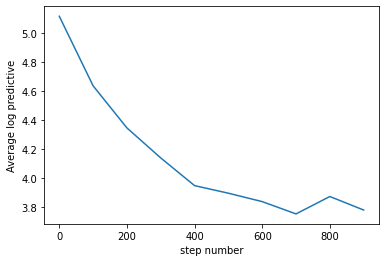

In [42]:
plt.plot(step_ids, average_log_predictives)
plt.xlabel("step number")
plt.ylabel("Average log predictive")

In [ ]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-0.0998,  0.1317, -0.0814,  0.3648, -0.0752, 13.9789,  7.3794, 13.0570,
         0.2388,  0.8030])
AutoDiagonalNormal.scale tensor([0.0745, 0.0968, 0.0863, 0.0740, 0.0972, 0.0683, 0.0942, 0.0787, 0.0739,
        0.0691])


In [ ]:
print('Actual value of w: {}'.format(w))
print('Fitted median of posterior: {}'.format(guide.quantiles([0.5])))

Actual value of w: [[ 0.          0.          0.          0.          0.         14.64492842
   7.13703273 13.4605053   0.16320927  0.75389908]]
Fitted median of posterior: {'linear.weight': tensor([[[-0.1095,  0.0610, -0.1645,  0.5143,  0.1007, 13.5663,  7.1861,
          13.3372,  0.3150,  0.7708]]])}


In [ ]:
y_train.squeeze().shape

torch.Size([80])

In [ ]:
guide.quantiles([0.5])

{'linear.weight': tensor([[[ 1.5882e-01, -1.9924e-01, -7.2937e-01,  1.1681e-02, -6.1948e-01,
           -1.3818e+01,  1.3608e+01,  1.5446e+01,  1.2169e+01, -7.8934e+00]]])}